# Problem Definition
In the WriteUpRight study, it was observed that EA and EC intervention strategies exhibited varying levels of effectiveness among different users.
To tailor the intervention strategy to individual user traits, we approach the selection of intervention strategies as **k-armed bandit problem**.

## Action Space
$A = \{EA, EC\}$

## Reward
Each intervention does not instantaneously finish. It lasts for certain amount of time before observing the impact, i.e., the postural reaction of the user. And the intervention duration varies for each intervention and among different users.

$R_t = 1$ if the intervention succeeds, which means the user corrects the posture before timeout.

Otherwise, $R_t = -1$

## State Space
We model it as a stateless and non-episodic problem, with the RL agent making decisions regardless of the environment and the user's status.


# Simulation
Each simulated user is modeled by a two dimensional random vector
$[p_{EA}, p_{EC}]$, where $p\in[0,1]$.
$p$ represents how likely a certain intervention strategies would succeed for this user.

Note: find the similar user and define the vector


## Implementation

In [ ]:
!pip install tf-agents
!pip install tf-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.1 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697630 sha256=d721cd3ec676d2f8e4922a3b2e1f50da80898936ad6c2dc621f3d4891e60fe9e
  Stored in directory: /root/.cache/pip/wheels/3d/6f/b4/3991d4fae11d0ecb0754c11cc1b4e7745012850da4efaaf0b1
Successfully built gym
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.22.0
    Uninstalling tensorflow-probability-0.22.0:
      Successfully uninstalled tensorflow-probability-0.22.0
  Attempting uninstall: pygame
    Found existing

In [ ]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
import numpy as np
import tensorflow as tf
import tf_agents.environments as tf_env
import tf_agents.specs as tf_specs
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import time_step as ts

# Encode action:
# EC = 0
# EA = 1
class TwoArmedBanditEnv(tf_env.py_environment.PyEnvironment):
    def __init__(self, user_model_vec):
        self._num_actions = 2
        self._user_model_vec = user_model_vec

        # True expected values for each arm.
        # It depends on the user model vector and the reward method
        self._true_action_values = 2 * np.array(user_model_vec, dtype=np.float32) - 1
        self._step_count = 0
        self._total_reward = 0.0
        self._dummy_observation = np.array([0.0, 0.0], dtype=np.float32)
        super(TwoArmedBanditEnv, self).__init__()

    def action_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=self._num_actions - 1, name='action')

    def observation_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(self._num_actions,), dtype=np.float32, minimum=0, name='observation')

    def _reset(self):
        self._step_count = 0
        self._total_reward = 0.0
        return ts.restart(observation = None)

    def _step(self, action):
        # TODO: integrate with the physical environment here

        # define the reward method
        # reward = np.random.normal(self._true_action_values[action], 1.0) # the gaussian reward
        reward = 1 if np.random.uniform(0,1) < self._user_model_vec[action] else -1

        self._step_count += 1
        self._total_reward += reward

        if self._step_count == 1000:  # Limit the number of steps for this example
            return ts.termination(observation = None, reward = reward)
        else:
            return ts.transition(observation=None, reward = reward)


In [ ]:
# TODO: refactor it to use TF agent base class
class UCB1Agent:
    def __init__(self, num_actions, explore_rate = 1.0):
        self.num_actions = num_actions
        self.action_values = [0.0] * num_actions
        self.action_counts = [0] * num_actions
        self.step_counts = 0
        self.c = explore_rate # exploration rate, the higher it is the more exploreation the agent does. The scale of it also relates to the scale of reward
        self.reward_history = []

    def select_action(self):
        if 0 in self.action_counts:
            # Play each action at least once to ensure exploration
            return self.action_counts.index(0)

        ucb_values = [0.0] * self.num_actions
        for i in range(self.num_actions):
            bonus = np.sqrt(2 * np.log(self.step_counts) / self.action_counts[i])
            ucb_values[i] = self.action_values[i] + self.c * bonus

        return np.argmax(ucb_values)

    def update_estimates(self, action, reward):
        self.action_counts[action] += 1
        self.step_counts += 1
        self.reward_history.append(reward)

        # value update
        self.action_values[action] = (
            (self.action_values[action] * (self.action_counts[action] - 1) + reward) /
            self.action_counts[action]
        )

    def get_current_average_reward(self):
        return np.mean(self.reward_history)


In [ ]:
def user_simulation(user_model_vec, num_iterations = 500, explore_rate = 2.0):
  # Create the environment
  # user_model_vec = [0.1, 0.9]
  true_action_value = 2 * np.array(user_model_vec) - 1
  env = TwoArmedBanditEnv(user_model_vec)

  # Create the UCB1 agent
  agent = UCB1Agent(num_actions=env.action_spec().maximum + 1, explore_rate=explore_rate)

  average_rewards = []
  rmse = []

  # Training loop
  for _ in range(num_iterations):
      # main stepping
      action = agent.select_action()
      time_step = env.step(action)
      agent.update_estimates(action, time_step.reward)

      # logs for ploting
      average_rewards.append(agent.get_current_average_reward())
      rmse.append(np.sqrt(np.mean((np.subtract(agent.action_values,true_action_value))**2)))

  print("True values: {}".format(true_action_value))
  print("Value estimates: {}".format(agent.action_values))
  print("Action counts: {}".format(agent.action_counts))

  # Evaluate the agent
  if False:
    total_reward = 0.0
    for _ in range(10):  # Test for 10 episodes
        time_step = env.reset()
        while not time_step.is_last():
            action = agent.select_action()
            time_step = env.step(action)
            total_reward += time_step.reward
    print(f'Average Reward of 10 episodes: {total_reward / 10 / 1000}')

  return average_rewards, rmse, agent.reward_history

## Simulate Single User

In [ ]:
# fix random seed
np.random.seed(0)

In [ ]:
average_rewards, rmse, reward_history = user_simulation(user_model_vec = [0.1, 0.9])

True values: [-0.8  0.8]
Value estimates: [-0.55, 0.7624999999999998]
Action counts: [20, 480]


Text(0.5, 0, 'Number of Iterations')

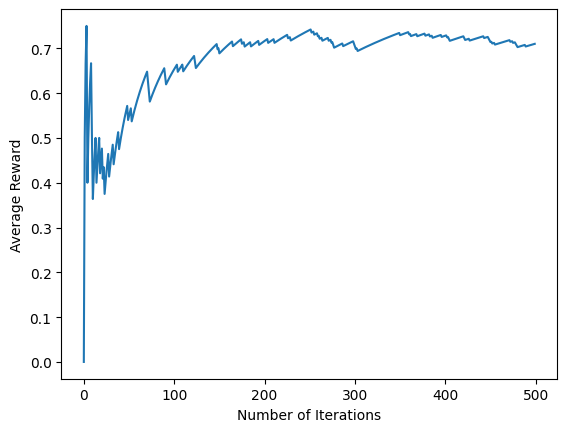

In [ ]:
import matplotlib.pyplot as plt
plt.plot(average_rewards)
plt.ylabel('Average Reward')
plt.xlabel('Number of Iterations')

Text(0.5, 0, 'Number of Iterations')

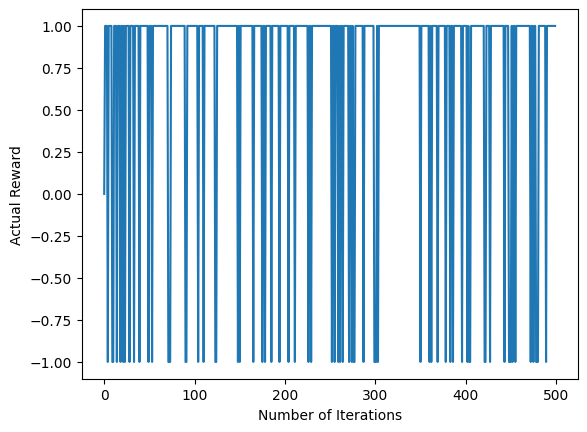

In [ ]:
# reward history
plt.plot(reward_history)
plt.ylabel('Actual Reward')
plt.xlabel('Number of Iterations')

Text(0.5, 0, 'Number of Iterations')

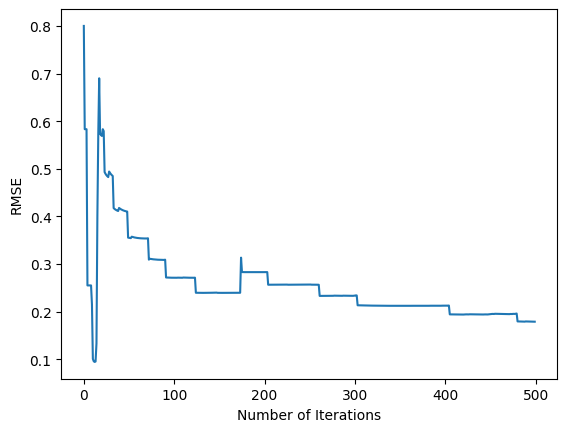

In [ ]:
# rmse of the esimated action value against the true action value
plt.plot(rmse)
plt.ylabel('RMSE')
plt.xlabel('Number of Iterations')

## Simulate N Users

In [ ]:
import pandas as pd
N = 10
num_iterations = 500
user_model_list = []
average_reward_tab = {"ts": list(range(num_iterations))}
for i in range(N):
  user_model_vec = np.random.uniform(0,1,2)
  user_model_list.append(user_model_vec)
  average_rewards, rmse, reward_history = user_simulation(user_model_vec, num_iterations, 1.0)
  average_reward_tab["User{}".format(i)] = average_rewards
average_reward_tab = pd.DataFrame(average_reward_tab).set_index("ts")

True values: [-0.52064622 -0.99901807]
Value estimates: [-0.4735729386892174, -1.0]
Action counts: [473, 27]
True values: [-0.16764434  0.93768157]
Value estimates: [-0.2857142857142857, 0.947261663286004]
Action counts: [7, 493]
True values: [-0.31275673 -0.74837634]
Value estimates: [-0.29094827586206873, -0.7222222222222222]
Action counts: [464, 36]
True values: [-0.18381289 -0.99454654]
Value estimates: [-0.19547325102880664, -1.0]
Action counts: [486, 14]
True values: [ 0.99820355 -0.05336261]
Value estimates: [0.9939271255060729, -0.3333333333333333]
Action counts: [494, 6]
True values: [ 0.54250512 -0.17389277]
Value estimates: [0.6168032786885249, -0.3333333333333333]
Action counts: [488, 12]
True values: [0.25634144 0.42870375]
Value estimates: [-0.16, 0.42736842105263156]
Action counts: [25, 475]
True values: [-0.24798321 -0.93241137]
Value estimates: [-0.2226804123711341, -1.0]
Action counts: [485, 15]
True values: [-0.65423253  0.79891331]
Value estimates: [-0.375, 0.747967

In [ ]:
print("Simulated user model:", user_model_list)

Simulated user model: [array([0.23967689, 0.00049096]), array([0.41617783, 0.96884078]), array([0.34362164, 0.12581183]), array([0.40809356, 0.00272673]), array([0.99910178, 0.4733187 ]), array([0.77125256, 0.41305362]), array([0.62817072, 0.71435187]), array([0.3760084 , 0.03379432]), array([0.17288373, 0.89945665]), array([0.82439269, 0.30816825])]


In [ ]:
import seaborn as sns
average_reward_tab.rename_axis(columns="User", inplace = True)

In [ ]:
average_reward_tab

User,User0,User1,User2,User3,User4,User5,User6,User7,User8,User9
ts,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.500000,0.500000,-0.500000,-0.500000,0.500000,-0.500000,0.500000,-0.500000,0.500000,-0.500000
2,-0.666667,0.666667,-0.666667,0.000000,0.000000,0.000000,0.666667,-0.666667,0.666667,-0.666667
3,-0.250000,0.750000,-0.750000,0.250000,0.250000,0.250000,0.750000,-0.750000,0.750000,-0.250000
4,-0.400000,0.800000,-0.800000,0.000000,0.400000,0.400000,0.800000,-0.800000,0.800000,-0.400000
...,...,...,...,...,...,...,...,...,...,...
495,-0.506048,0.929435,-0.320565,-0.215726,0.977823,0.590726,0.401210,-0.243952,0.731855,0.655242
496,-0.503018,0.929577,-0.321932,-0.217304,0.977867,0.591549,0.398390,-0.245473,0.728370,0.655936
497,-0.500000,0.929719,-0.323293,-0.218875,0.977912,0.592369,0.395582,-0.242972,0.728916,0.656627


<Axes: xlabel='ts'>

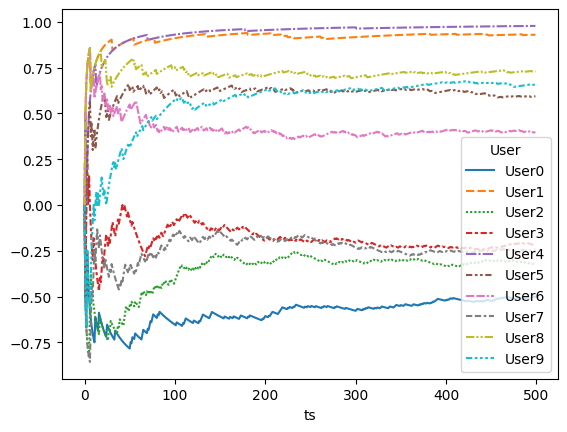

In [ ]:
sns.lineplot(data=average_reward_tab)

In [ ]:
average_reward_tab_long = average_reward_tab.copy(True)
average_reward_tab_long['ts'] = average_reward_tab.index.values
average_reward_tab_long = pd.melt(average_reward_tab_long, id_vars = ['ts'], value_vars=average_reward_tab.columns.values)

In [ ]:
average_reward_tab_long

,ts,User,value
0,0,User0,0.000000
1,1,User0,-0.500000
2,2,User0,-0.666667
3,3,User0,-0.250000
4,4,User0,-0.400000
...,...,...,...
4995,495,User9,0.655242
4996,496,User9,0.655936
4997,497,User9,0.656627
4998,498,User9,0.657315


<Axes: xlabel='ts', ylabel='value'>

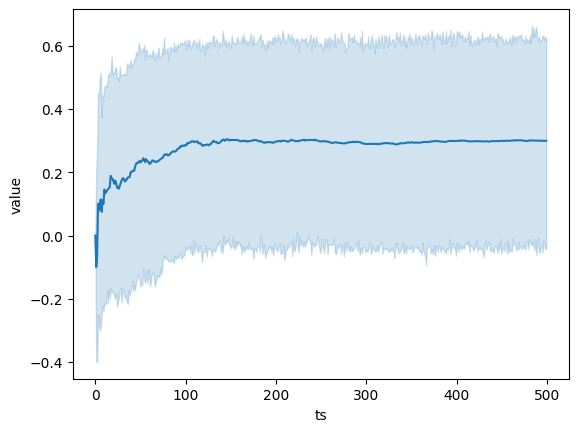

In [ ]:
sns.lineplot(data=average_reward_tab_long, x = 'ts', y='value')